## Imports

In [1]:
import functools
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.4"

from clu import metric_writers
import numpy as np
import jax
import jax.numpy as jnp
from jax.experimental import sparse
import matplotlib.pyplot as plt
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

In [2]:
from ISP_baseline.src import models, trainers, utils
from ISP_baseline.models import WideBNet 

from swirl_dynamics import templates
from swirl_dynamics.lib import metrics
from pysteps.utils.spectral import rapsd

Pysteps configuration file found at: /share/data/willett-group/oortsang/miniconda/envs/jaxisp-env/lib/python3.11/site-packages/pysteps/pystepsrc



In [3]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

### Dataset

In [4]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

idx_flatten_to_morton = utils.flatten_to_morton_indices(L, s)
idx_morton_to_flatten = utils.morton_to_flatten_indices(L, s)

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
batch_size = 16

# Number of training datapoints.
# NTRAIN = 21000
NTRAIN = 2000

In [5]:
# training_data_path = os.path.abspath('../..') + '/data/10hsquares_trainingdata'
training_data_path = os.path.join("data", "traindata_L3s10_multifreq_square_3_5_10_h_freq_2.5_5_10")

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{training_data_path}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{training_data_path}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :]
    tmp2 = f[keys[4]][:NTRAIN, :]
    tmp3 = f[keys[5]][:NTRAIN, :]
    scatter_re = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_re = scatter_re[:, idx_flatten_to_morton, :]
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :]
    tmp2 = f[keys[1]][:NTRAIN, :]
    tmp3 = f[keys[2]][:NTRAIN, :]
    scatter_im = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_im = scatter_im[:, idx_flatten_to_morton, :]
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

mean0, std0 = np.mean(scatter[:,:,:,0]), np.std(scatter[:,:,:,0])
mean1, std1 = np.mean(scatter[:,:,:,1]), np.std(scatter[:,:,:,1])
mean2, std2 = np.mean(scatter[:,:,:,2]), np.std(scatter[:,:,:,2])

scatter[:,:,:,0] -= mean0
scatter[:,:,:,0] /= std0
scatter[:,:,:,1] -= mean1
scatter[:,:,:,1] /= std1
scatter[:,:,:,2] -= mean2
scatter[:,:,:,2] /= std2

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [6]:
dict_data = {"eta": eta_re}
dict_data["scatter"] = scatter
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

### Architecture

In [7]:
core_module = WideBNet.WideBNetModel(
     L = L, s = s, r = r, NUM_RESNET = 3, NUM_CNN = 3, idx_morton_to_flatten = idx_morton_to_flatten
)

In [8]:
Model = models.DeterministicModel(
    input_shape = scatter[0].shape,
    core_module = core_module
)

In [9]:
rng = jax.random.PRNGKey(888)
params = Model.initialize(rng)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print('Number of trainable parameters:', param_count)

Number of trainable parameters: 1914061


### Training

In [10]:
epochs = 100
num_train_steps = NTRAIN * epochs // 16  #@param
workdir = os.path.abspath('') + "/tmp/WideBNet10squares"  #@param
init_value = 5e-3
transition_steps = 2000
decay_rate = 0.95
ckpt_interval = 2000  #@param
max_ckpt_to_keep = 3  #@param

In [11]:
trainer = trainers.DeterministicTrainer(
    model=Model, 
    rng=jax.random.PRNGKey(42), 
    optimizer=optax.adam(
        learning_rate=optax.exponential_decay(
            init_value = init_value, 
            transition_steps = transition_steps, 
            decay_rate = decay_rate, 
            staircase = True),
    ),
)

In [12]:
templates.run_train(
    train_dataloader=dataset,
    trainer=trainer,
    workdir=workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    metric_aggregation_steps = 100,
    eval_dataloader = eval_dataloader,
    eval_every_steps = 5000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
            eval_monitors=("eval_rrmse_mean",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/12500 [00:00<?, ?step/s]

### Inference

In [13]:
trained_state = trainers.TrainState.restore_from_orbax_ckpt(
    f"{workdir}/checkpoints", step=None
)

In [14]:
inference_fn = trainers.DeterministicTrainer.build_inference_fn(
    trained_state, core_module
)

In [15]:
# Loading and preprocessing perturbation data (eta)
# test_data_path = os.path.abspath('../..') + '/data/10hsquares_testdata'
test_data_path = os.path.join("data", "testdata")

with h5py.File(f'{test_data_path}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_test = np.stack([blur_fn(img) for img in eta_re]).astype('float32')


# Loading and preprocessing scatter data (Lambda)
# with h5py.File(f'{test_data_path}/scatter_order_8.h5', 'r') as f:
with h5py.File(f'{test_data_path}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:, :]
    tmp2 = f[keys[4]][:, :]
    tmp3 = f[keys[5]][:, :]
    scatter_re = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_re = scatter_re[:, idx_flatten_to_morton, :]
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:, :]
    tmp2 = f[keys[1]][:, :]
    tmp3 = f[keys[2]][:, :]
    scatter_im = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_im = scatter_im[:, idx_flatten_to_morton, :]
    # Combine real and imaginary parts
    scatter_test = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

scatter_test[:,:,:,0] -= mean0
scatter_test[:,:,:,0] /= std0
scatter_test[:,:,:,1] -= mean1
scatter_test[:,:,:,1] /= std1
scatter_test[:,:,:,2] -= mean2
scatter_test[:,:,:,2] /= std2

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3


In [16]:
test_batch = 100
test_dataset = tf.data.Dataset.from_tensor_slices((scatter_test, eta_test))
test_dataset = test_dataset.batch(test_batch)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.as_numpy_iterator()


In [17]:
validation_errors_rrmse = [] 
validation_errors_rapsd = [] 
eta_pred = np.zeros(eta_test.shape)

rrmse = functools.partial(
        metrics.mean_squared_error,
        sum_axes=(-1, -2),
        relative=True,
        squared=False,
    )

b = 0
for batch in test_dataset:
    pred = inference_fn(batch[0])
    eta_pred[b*test_batch:(b+1)*test_batch,:,:] = pred
    b += 1
    true = batch[1]
    validation_errors_rrmse.append(rrmse(pred=pred, true=true))
    for i in range(true.shape[0]):
        validation_errors_rapsd.append(np.abs(np.log(rapsd(pred[i],fft_method=np.fft)/rapsd(true[i],fft_method=np.fft))))

print('relative root-mean-square error = %.3f' % (np.mean(validation_errors_rrmse)*100), '%') 
print('mean energy log ratio = %.3f' % np.mean(validation_errors_rapsd)) 


relative root-mean-square error = 99.772 %
mean energy log ratio = inf


In [18]:
#with h5py.File("results_widebnet_10squares.h5", "w") as f:
#    f.create_dataset('eta', data=eta_test)
#    f.create_dataset('eta_pred', data=eta_pred)


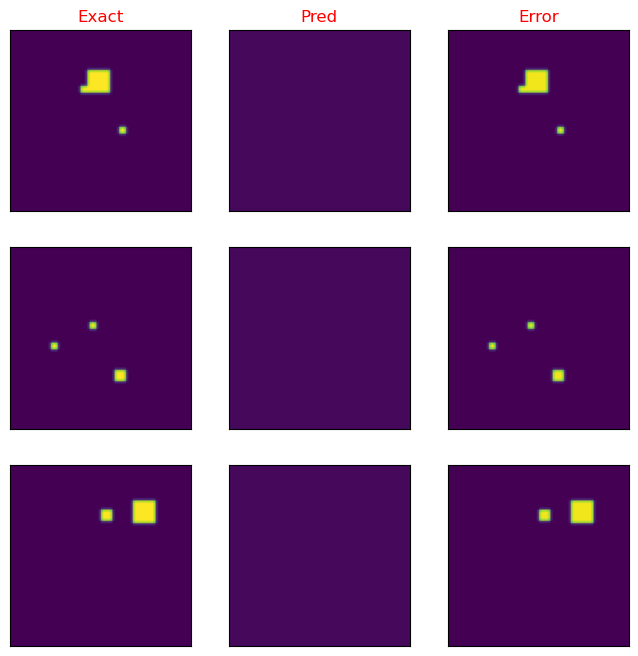

In [19]:
import random

fig = plt.figure(figsize=(8,8))
NPLOT = 3
for kk in range(NPLOT):
    k = random.randint(0, test_batch)
    plt.subplot(NPLOT, 3, kk*NPLOT + 1)
    plt.imshow(batch[1][k,:,:])
    plt.xticks([]); plt.yticks([]); clim = plt.gci().get_clim();
    if kk == 0:
        plt.title('Exact', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 2)
    plt.imshow(pred[k,:,:])
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Pred', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 3)
    plt.imshow(batch[1][k,:,:]-pred[k,:,:])
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Error', color='red')                
plt.show()
#fig.savefig('widebnet10squares.png')